## Question 1

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import math

### Optimization Problem

The problem can be framed as a convex optimization problem since the objective is convex, the inequality constraints are convex and the equality constraints are linear. In particular, note that the objective function is a composition of the matrix sum of squares and the maximum function. We frame the problem as follows <br>

min. $\frac{1}{(T+1) N} \sum_{t=1}^{T+1} \sum_{i=1}^{N} max\{q_{t, i}^{\operatorname{tar}}-q_{t, i}, 0\}^2$ <br>
s.t.  $c \geq 0, q \geq 0$ <br>
&emsp; &ensp; $q_{t+1, i} = q_{t, i} + c_{t, i}, t=1 \ldots T, i=1 \ldots N$ <br>
&emsp; &ensp; $\sum_{i=1}^{N} c_{t, i} \leq C^{\max }$ <br>
&emsp; &ensp; $q_{1, i} = q_{init}$ <br>

where the indices $t$ and $i$ are adjusted according to the usage keeping in mind that $q$ is a $T+1$ vector while $c$ is a $T$ vector.


### Implementation

In [2]:
# problem data

N = 4
T = 90
Cmax = 3
q_init = np.array([20, 0, 30, 25])

q_des = np.array([60, 100, 75, 125])
gamma = np.array([0.5, 0.3, 2.0, 0.6])

q_tar = np.zeros((T+1, N))
for t in range(T+1):
    for i in range(N):
        q_tar[t][i] = math.pow((t+1)/(T+1), gamma[i])*q_des[i]

In [3]:
# defining variables

q = cp.Variable((T+1, N), nonneg=True)
c = cp.Variable((T, N), nonneg=True)

In [4]:
# adding constraints

cons = [q[0] == q_init]
cons += [cp.sum(c, axis=1) <= Cmax]

for t in range(T):
    for i in range(N):
        cons += [q[t+1][i] == q[t][i] + c[t][i]]

In [5]:
# defining the objective function and the objective

objf = cp.sum_squares(cp.pos(q_tar-q))
obj = cp.Minimize((1/(N*(T+1)))*objf)

In [6]:
# calculating the RMS shortfall

prob = cp.Problem(obj, cons)
print("The optimal RMS shortfall is {}".format(np.sqrt(prob.solve())))

The optimal RMS shortfall is 8.847699653781177


Next, we plot the optimal vs. target state of charge for each vehicle.

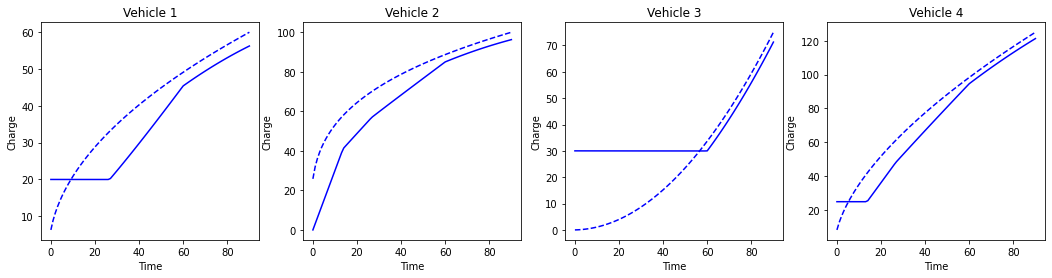

In [7]:
plt.subplot(1, 4, 1);
plt.plot(q_tar[:, 0], 'b--');
plt.plot(q.value[:, 0], 'b');
plt.title("Vehicle 1")
plt.xlabel("Time")
plt.ylabel("Charge")

plt.subplot(1, 4, 2);
plt.plot(q_tar[:, 1], 'b--');
plt.plot(q.value[:, 1], 'b');
plt.title("Vehicle 2")
plt.xlabel("Time")
plt.ylabel("Charge")

plt.subplot(1, 4, 3);
plt.plot(q_tar[:, 2], 'b--');
plt.plot(q.value[:, 2], 'b');
plt.title("Vehicle 3")
plt.xlabel("Time")
plt.ylabel("Charge")

plt.subplot(1, 4, 4);
plt.plot(q_tar[:, 3], 'b--');
plt.plot(q.value[:, 3], 'b');
plt.title("Vehicle 4")
plt.xlabel("Time")
plt.ylabel("Charge")

fig = plt.gcf()
fig.set_size_inches((18,4))

The stackplot for the optimal charging energies is as follows.

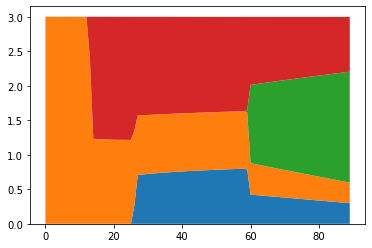

In [8]:
plt.stackplot(np.arange(T), c.value.T);

We solve the problem for the constant charging case.

In [9]:
# problem data

total = 0
for j in range(N):
    total += q_des[j] - q_init[j]
    
theta = (q_des - q_init)*(1/(total))

In [10]:
# calculating charging states and energies

c_cons = np.zeros((T, N))
for i in range(N):
    c_cons[:, i] = theta[i]*Cmax*np.ones(T)
    
q_cons = np.zeros((T+1, N))
q_cons[0] = q_init
for t in range(T):
    q_cons[t+1] = q_cons[t] + c_cons[t]

In [11]:
# calculating RMS shortfall

pos = np.maximum(q_tar-q_cons, np.zeros((T+1, N)))
rms_cons = np.sqrt((1/(N*(T+1)))*np.sum(np.square(pos)))
print("The RMS shortfall for the constant case is {}".format(rms_cons))

The RMS shortfall for the constant case is 16.679663934110675


We plot the same plots for the constant charging case.

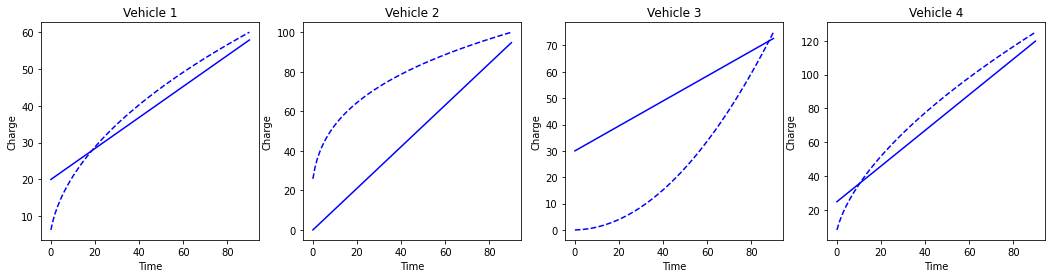

In [12]:
plt.subplot(1, 4, 1);
plt.plot(q_tar[:, 0], 'b--');
plt.plot(q_cons[:, 0], 'b');
plt.title("Vehicle 1")
plt.xlabel("Time")
plt.ylabel("Charge")

plt.subplot(1, 4, 2);
plt.plot(q_tar[:, 1], 'b--');
plt.plot(q_cons[:, 1], 'b');
plt.title("Vehicle 2")
plt.xlabel("Time")
plt.ylabel("Charge")

plt.subplot(1, 4, 3);
plt.plot(q_tar[:, 2], 'b--');
plt.plot(q_cons[:, 2], 'b');
plt.title("Vehicle 3")
plt.xlabel("Time")
plt.ylabel("Charge")

plt.subplot(1, 4, 4);
plt.plot(q_tar[:, 3], 'b--');
plt.plot(q_cons[:, 3], 'b');
plt.title("Vehicle 4")
plt.xlabel("Time")
plt.ylabel("Charge")

fig = plt.gcf()
fig.set_size_inches((18,4))

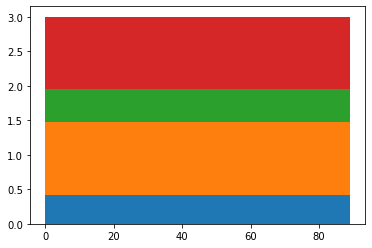

In [13]:
plt.stackplot(np.arange(T), c_cons.T);

We can compare the charging energies for the two cases in the following plot.

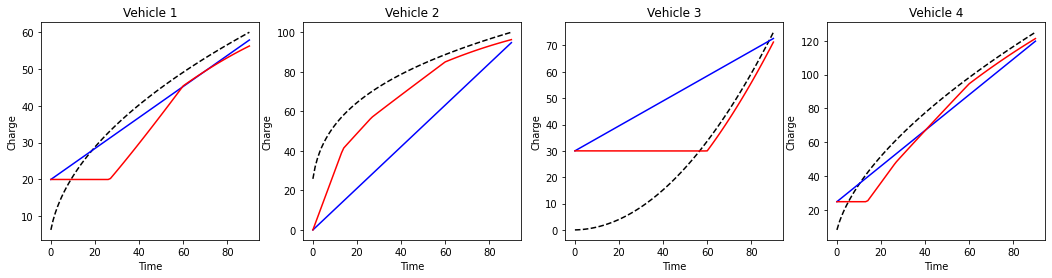

In [14]:
plt.subplot(1, 4, 1);
plt.plot(q_tar[:, 0], 'k--');
plt.plot(q_cons[:, 0], 'b');
plt.plot(q.value[:, 0], 'r');
plt.title("Vehicle 1")
plt.xlabel("Time")
plt.ylabel("Charge")

plt.subplot(1, 4, 2);
plt.plot(q_tar[:, 1], 'k--');
plt.plot(q_cons[:, 1], 'b');
plt.plot(q.value[:, 1], 'r');
plt.title("Vehicle 2")
plt.xlabel("Time")
plt.ylabel("Charge")

plt.subplot(1, 4, 3);
plt.plot(q_tar[:, 2], 'k--');
plt.plot(q_cons[:, 2], 'b');
plt.plot(q.value[:, 2], 'r');
plt.title("Vehicle 3")
plt.xlabel("Time")
plt.ylabel("Charge")

plt.subplot(1, 4, 4);
plt.plot(q_tar[:, 3], 'k--');
plt.plot(q_cons[:, 3], 'b');
plt.plot(q.value[:, 3], 'r');
plt.title("Vehicle 4")
plt.xlabel("Time")
plt.ylabel("Charge")

fig = plt.gcf()
fig.set_size_inches((18,4))

The red lines show optimal charging values whereas the blue lines show the constant case. Black is the target value. It can be seen that the optimal charging energies come closer to the target than do the constant charging energies.